In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import os
from dotenv import load_dotenv
from google.cloud import storage
from google.oauth2 import service_account   

#Specify the path to the service account key file (found in .env)
load_dotenv()
gee_key_path = os.getenv('GEE_AUTH_KEY_PATH')
project = 'mpg-projects'

# Define the correct scope for Earth Engine
SCOPES = ['https://www.googleapis.com/auth/cloud-platform']

# Load the service account credentials
credentials = service_account.Credentials.from_service_account_file(
    gee_key_path, scopes=SCOPES
)
# Initialize Earth Engine
storage_client = storage.Client(credentials=credentials)
ee.Initialize(credentials=credentials, project=project)
print("Earth Engine initialized successfully!")
(credentials.project_id, (credentials.service_account_email))

Earth Engine initialized successfully!


('mpg-projects', '790312891037-compute@developer.gserviceaccount.com')

PRISM resolution: 927.6624232401731 meters


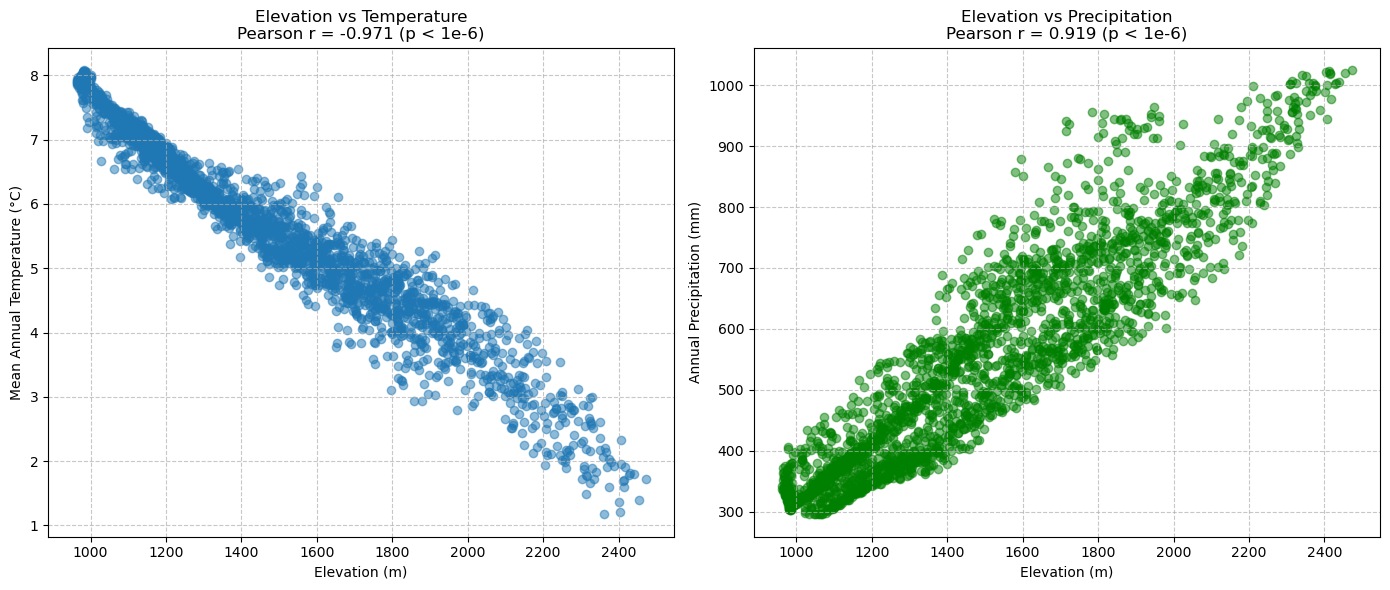

PRISM resolution confirmed: 927.6624232401731 meters
Number of sampled points: 2378
Elevation-Temperature correlation: -0.971 (p < 1e-6)
Elevation-Precipitation correlation: 0.919 (p < 1e-6)


In [9]:
# Define AOI with the coordinates provided
aoi = ee.Geometry.Polygon([
    [[-114.08229911631165, 46.12679350521872],
     [-113.84197318857727, 46.12679350521872],
     [-113.84197318857727, 46.80969368443738],
     [-114.08229911631165, 46.80969368443738],
     [-114.08229911631165, 46.12679350521872]]
])

# Load PRISM 30-year climate normals (1991-2020)
prism_dataset = ee.ImageCollection("OREGONSTATE/PRISM/Norm91m")

# Get a specific band to check resolution (fix for the error)
prism_tmean = prism_dataset.select('tmean').first()
prism_resolution = prism_tmean.projection().nominalScale()
print(f"PRISM resolution: {prism_resolution.getInfo()} meters")  # Should be around 800m

# Get mean annual temperature and precipitation
prism_temp = prism_dataset.select('tmean').mean()
prism_precip = prism_dataset.select('ppt').sum()

# Load elevation data (SRTM)
elevation = ee.Image("USGS/SRTMGL1_003").select('elevation')

# Resample elevation to PRISM resolution
elevation_resampled = elevation.resample('bilinear').reproject(
    crs=prism_temp.projection().crs(),
    scale=prism_resolution
)

# Combine datasets
combined_image = ee.Image.cat([
    elevation_resampled.rename('elevation'),
    prism_temp.rename('temperature'),
    prism_precip.rename('precipitation')
])

# Sample points within the AOI
points = combined_image.sample(
    region=aoi,
    scale=prism_resolution,
    geometries=True
)

# Export data to pandas DataFrame - Fix for the error
# Using the correct method to convert Earth Engine FeatureCollection to pandas DataFrame
point_data_fc = points.getInfo()
point_data = pd.DataFrame([feature['properties'] for feature in point_data_fc['features']])

# Calculate Pearson correlation
elev_temp_corr, elev_temp_p = pearsonr(point_data['elevation'], point_data['temperature'])
elev_precip_corr, elev_precip_p = pearsonr(point_data['elevation'], point_data['precipitation'])

# Format p-values to show "p < 1e-6" when extremely small
temp_p_formatted = "p < 1e-6" if elev_temp_p < 1e-6 else f"p = {elev_temp_p:.4f}"
precip_p_formatted = "p < 1e-6" if elev_precip_p < 1e-6 else f"p = {elev_precip_p:.4f}"

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Elevation vs Temperature
ax1.scatter(point_data['elevation'], point_data['temperature'], alpha=0.5)
ax1.set_xlabel('Elevation (m)')
ax1.set_ylabel('Mean Annual Temperature (°C)')
ax1.set_title(f'Elevation vs Temperature\nPearson r = {elev_temp_corr:.3f} ({temp_p_formatted})')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Elevation vs Precipitation
ax2.scatter(point_data['elevation'], point_data['precipitation'], alpha=0.5, color='green')
ax2.set_xlabel('Elevation (m)')
ax2.set_ylabel('Annual Precipitation (mm)')
ax2.set_title(f'Elevation vs Precipitation\nPearson r = {elev_precip_corr:.3f} ({precip_p_formatted})')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('elevation_climate_correlations.png', dpi=300)
plt.show()

# Also update the print statements
print(f"PRISM resolution confirmed: {prism_resolution.getInfo()} meters")
print(f"Number of sampled points: {len(point_data)}")
print(f"Elevation-Temperature correlation: {elev_temp_corr:.3f} ({temp_p_formatted})")
print(f"Elevation-Precipitation correlation: {elev_precip_corr:.3f} ({precip_p_formatted})")